# 评价函数

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,precision_score,accuracy_score,recall_score,f1_score
from sklearn.datasets import load_iris

In [2]:
## 定义评价函数
def score_result(y, y_pred):
    # 混淆矩阵
    confusion = confusion_matrix(y, y_pred)
    print(' Confusion Matrix: \n', confusion)

    # 准确率
    acc = accuracy_score(y, y_pred)
    print(' accuracy = %.4f'%(acc))

    # 精度
    precision = precision_score(y, y_pred, average = 'weighted')
    print(' precision = %.4f'%(precision))

    # 召回率
    recall = recall_score(y,y_pred, average = 'weighted')
    print(' recall = %.4f'%(recall))

    # F1
    F1 = f1_score(y, y_pred, average = 'weighted')
    print(' F1 score = %.4f'%(F1))
    return confusion, acc, precision, recall, F1

# 数据集

In [3]:
## 二分类数据集
name = ['Sample code number','Clump Thickness', 'Uniformity of Cell Size','Uniformity of Cell Shape','Marginal Adhesion', 'Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses','Class']
cancer = pd.read_csv('breast-cancer-wisconsin.data', names=name)
cancer = cancer.drop(index=(cancer.loc[(cancer['Bare Nuclei']=='?')].index))
tmp = [int(i) for i in cancer['Bare Nuclei']]
cancer['Bare Nuclei'] = tmp
cancer['Class'] = cancer['Class'].replace(2,0).replace(4,1)

## 多分类数据集
iris = load_iris(True)

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass return_X_y=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


# 判别方法

## 1. QDA二次判别分析
当不同分类样本的协方差矩阵相同时，使用线性判别分析；当不同分类样本的协方差矩阵不同时，则应该使用二次判别。  
其中为先验概率，为频率   

QDA的判别函数值:

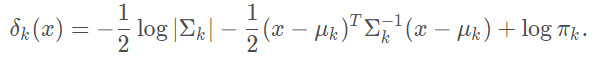

In [ ]:
## 定义QDA函数
def QDA(X, Y):
    n, p = X.shape
    classes, label = np.unique(Y, return_inverse=True)
    # 先验概率
    prior = np.bincount(Y)/n
    # 均值矩阵 
    means = np.zeros((len(classes), p))
    np.add.at(means, label, X)
    # print(means)
    # 每个类别的均值
    mu = means/np.expand_dims(np.bincount(Y),1)
    # print(mu_i)
    # 每个类别的协方差
    cov = [np.cov(X[Y == group].T) for idx, group in enumerate(classes)]

    value = np.zeros((n, len(classes)))
    for i in range(len(classes)):
        sigma_i = cov[i]
        U, S, V = np.linalg.svd(sigma_i)  #SVD分解
        sn = np.linalg.inv(np.diag(S))    #求逆
        sigma_i_inv = np.dot(np.dot(V.T, sn), U.T)
        Xm = X-mu[i]
        value[:, i] = -0.5*np.log(np.expand_dims(np.linalg.det(sigma_i), axis=0)) - 0.5*np.multiply(np.dot(Xm, sigma_i_inv).T, Xm.T).sum(axis=0)

    value = value + np.log(np.expand_dims(prior, axis = 0))
    likelihood = np.exp(value - value.max(axis=1)[:, np.newaxis])
    prob = likelihood / likelihood.sum(axis = 1)[:, np.newaxis]
    pclass = np.argmax(value, axis = 1)
    return prob, pclass

In [ ]:
## iris数据测试
X, Y = load_iris(True)
y_pred = QDA(X,Y)[1]
score_result(Y, y_pred)
# plot_result(X, Y, y_pred)

## 2. naive beyes贝叶斯判别
贝叶斯公式：  
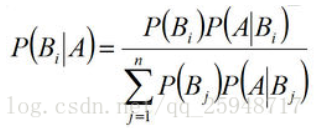

In [4]:
import pandas as pd
import scipy
import random
from sklearn.model_selection import train_test_split
import math

X, Y = load_iris(True)
data = np.concatenate((X,np.expand_dims(Y,1)), axis=1)
train, test = train_test_split(data, test_size=0.3, random_state=66)

def seprateByClass(dataset):
    seprate_dict = {}
    info_dict = {}
    for vector in dataset:
        if vector[-1] not in seprate_dict:
            seprate_dict[vector[-1]] = []
            info_dict[vector[-1]] = 0
        seprate_dict[vector[-1]].append(vector)
        info_dict[vector[-1]] +=1
    return seprate_dict,info_dict
train_separated, train_info = seprateByClass(train)
train_separated

# 先验概率
def prior_prob(dataset, dataset_info):
    prior = {}
    sample_sum = len(dataset)
    for class_value, sample_nums in dataset_info.items():
        prior[class_value] = sample_nums/float(sample_sum)
    return prior
prior = prior_prob(train, train_info)
prior

{1.0: 0.3142857142857143, 0.0: 0.3333333333333333, 2.0: 0.3523809523809524}

In [5]:
# 均值
def mean(list):
    list = [float(x) for x in list] #字符串转数字
    return sum(list)/float(len(list))

# 方差
def var(list):
    list = [float(x) for x in list]
    avg = mean(list)
    var = sum([math.pow((x-avg),2) for x in list])/float(len(list)-1)
    return var

## 定义概率分布
def calculateProb(x,mean,var):
    exponent = math.exp(math.pow((x-mean),2)/(-2*var))
    p = (1/math.sqrt(2*math.pi*var))*exponent
    return p


## 计算每个属性的均值和方差
def sumA(dataset):
    dataset = np.delete(dataset,-1,axis = 1)
    summaries = [(mean(attr),var(attr)) for attr in zip(*dataset)]
    return summaries

train_sum = sumA(train)
train_sum

# 按类别提取变量特征
def summarizeByClass(data):
    dataset_separated, dataset_info = seprateByClass(data)
    summarize_by_class = {}
    for classValue, vector in dataset_separated.items():
        summarize_by_class[classValue] = sumA(vector)
    return summarize_by_class

train_sum_by_class = summarizeByClass(train)
train_sum_by_class

# 按类别将每个变量概率相乘
def calculateClassProb(input_data,train_sum_by_class):
    prob = {}
    for class_value, summary in train_sum_by_class.items():
        prob[class_value] = 1
        for i in range(len(summary)):
            mean,var = summary[i]
            x = input_data[i]
            p = calculateProb(x,mean,var)
        prob[class_value] *=p
    return prob

In [6]:
def bayesian(input_data):
    prior = prior_prob(train, train_info)
    train_sum_by_class = summarizeByClass(train)
    classprob_dict = calculateClassProb(input_data, train_sum_by_class)
    result = {}
    for value, prob in classprob_dict.items():
        p = prob*prior[value]
        result[value] = p
    return max(result,key=result.get)

pred = []
for i in data:
    input_data = i[:-1]
    label = i[-1]
    pred.append(bayesian(input_data))
    
score_result(Y, pred)

 Confusion Matrix: 
 [[50  0  0]
 [ 0 48  2]
 [ 0  4 46]]
 accuracy = 0.9600
 precision = 0.9605
 recall = 0.9600
 F1 score = 0.9600


(array([[50,  0,  0],
        [ 0, 48,  2],
        [ 0,  4, 46]], dtype=int64),
 0.96,
 0.9604700854700855,
 0.96,
 0.9599839935974391)

## 3. FisherD判别  
原理：FISHER判别思想是投影，使多维问题简化为一维问题来处理。  
选择一个适当的投影轴,使所有的样品点都投影到这个轴上得到一个投影值。  
对这个投影轴的方向的要求是：使每一类内的投影值所形成的类内离差尽可能小，  
而不同类间的投影值所形成的类间离差尽可能大。
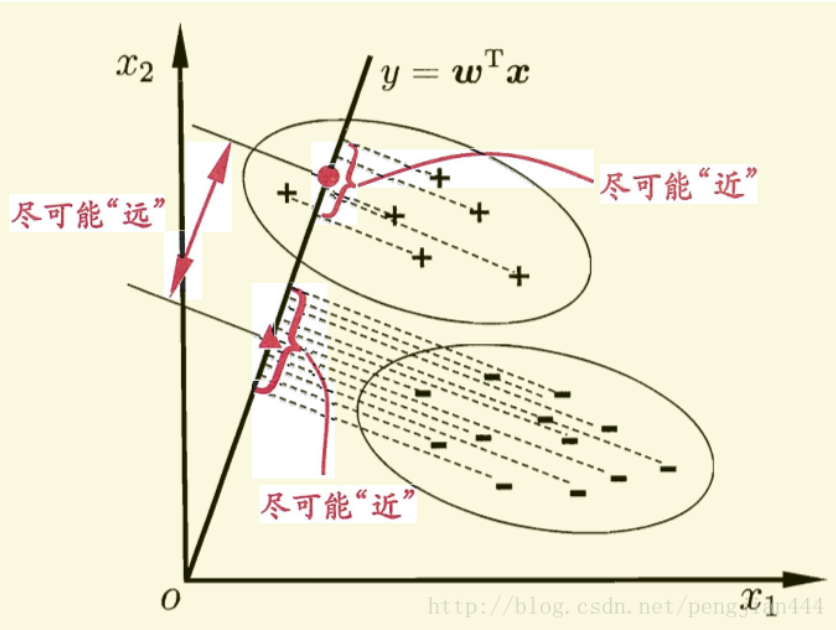

In [ ]:
def fisher(X, Y, test):
    n, p = X.shape
    classes, label = np.unique(Y, return_inverse=True)
    # 均值矩阵 
    means = np.zeros((len(classes), p))
    np.add.at(means, label, X)
    # print(means)
    # 每个类别的均值
    mu = means/np.expand_dims(np.bincount(Y),1)
    # print(mu_i)
    # 每个类别的协方差
    cov = [np.cov(X[Y == group].T) for idx, group in enumerate(classes)]

    ## 第一和第二类分类
    cov_1, u1 = cov[0], mu[0]
    cov_2, u2 = cov[1], mu[1]
    s_w = cov_1 + cov_2
    u, s, v = np.linalg.svd(s_w)
    s_w_inv = np.dot(np.dot(v.T, np.linalg.inv(np.diag(s))), u.T)
    w = np.dot(s_w_inv, u1 - u2)

    ## 找出中心点
    center_1 = np.dot(w.T, u1)
    center_2 = np.dot(w.T, u2)
    pos = np.dot(w.T, test)
#     print(abs(pos-center_1))
#     print(abs(pos-center_2))
    if abs(pos - center_1) < abs(pos - center_2):
        return 0
    else: return 1
    ## 则X[1]属于第一类

In [ ]:
## cancer数据测试
X_c = cancer[['Clump Thickness', 'Uniformity of Cell Size','Uniformity of Cell Shape','Marginal Adhesion', 'Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses']].values
Y_c = cancer['Class'].values

pred = []
for i in X_c:
    pred.append(fisher(X_c,Y_c, i))
score_result(Y_c, pred)

## 4. logit回归判别--二分类算法  
sigmoid函数：  
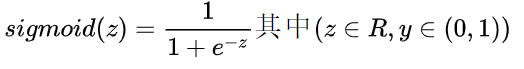  
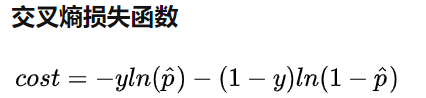  
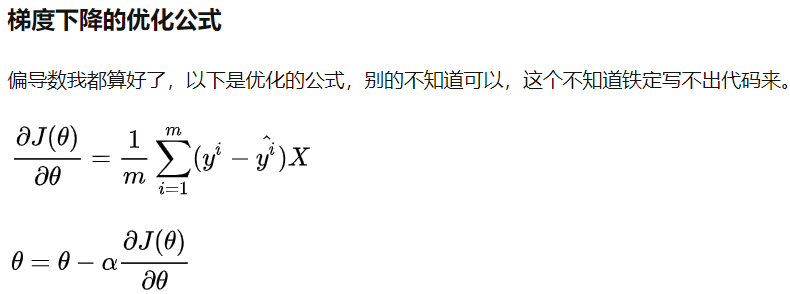  

In [ ]:
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_c, Y_c, test_size=0.2, random_state=66)
x_train

# 生成偏置b,加上常数列
X_b = np.hstack([np.ones((len(x_train), 1)), x_train])
# 初始化系数theta
theta = np.zeros(X_b.shape[1])

In [ ]:
#定义sigmoid函数
def sigmoid(x):
    return 1.0/(1+exp(-x))

# 损失函数
def J(theta):
    y_hat = sigmoid(X_b.dot(theta))
    m = - np.sum(y_train*np.log(y_hat) + (1-y_train)*np.log(1-y_hat)) / len(y_train)
    return m

# 梯度
def dJ(theta):
    dm = X_b.T.dot(sigmoid(X_b.dot(theta)) - y_train) / len(y_train)
    return dm

# 梯度下降法优化
iter_num = 0
max_iter = 10000
learing_rate = 0.01
while iter_num < max_iter:
    iter_num += 1
    last_theta = theta
    theta = theta - learing_rate * dJ(theta)
    if (abs(J(theta) - J(last_theta)) < 1e-7):
        break

In [ ]:
print(theta)
y_predict = sigmoid(X_b.dot(theta))
y_predict = np.array(y_predict >= 0.5 ,dtype='int')
# y_predict
score_result(y_train, y_predict)